In [32]:
# Import the required Libraries
import pandas as pd
import panel as pn
import holoviews as hv
import numpy as np
import hvplot.pandas
from concurrent.futures import as_completed, ThreadPoolExecutor
import PyForks.exceptions
from PyForks.region import Region
from PyForks.user import User
from tqdm import tqdm
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from shapely.geometry import Polygon
import geopandas as gpd
import matplotlib.pyplot as plt
pn.extension()

## Set the Notebook Global Variables to start to build the Dashboard

In [4]:
TRAILFORKS_USER = ""                        # Your Trailforks Username
TRAILFORKS_PASS = ""                        # Your Trailforks Password
TRAILFORKS_REGION = "west-lake-marion-park" # The Trailforks Region you want to build the dashboard for

In [5]:
def run_job(users: list, tf_user: User) -> list:
    results = []
    thread_list = []
    pbar = tqdm(total=len(users))
    with ThreadPoolExecutor() as executor:
        thread_list = [ executor.submit(tf_user.get_user_info, user) for user in users ]
        
    for thread in as_completed(thread_list):
        try:
            results.append(thread.result())
        except PyForks.exceptions.InvalidUser as e:
            pass
        pbar.update(1)
        
    pbar.close()
    return results

## Download the Region Data

We now need to grab the trailforks region ridecounts and ridelogs to start to build all the graphs

In [6]:
tf_region = Region(username=TRAILFORKS_USER,password=TRAILFORKS_PASS)
tf_user = User(username=TRAILFORKS_USER,password=TRAILFORKS_PASS)
tf_region.login()
tf_user.login()

region_ridelogs_df = tf_region.get_all_region_ridelogs(TRAILFORKS_REGION)
region_ridecounts_df = tf_region.get_region_ridecounts(TRAILFORKS_REGION)

# Now we want to get information on all the riders who ride the region being analyzed
region_riders = region_ridelogs_df.username.unique().tolist()
region_rider_info = run_job(region_riders, tf_user)
region_rider_df = pd.DataFrame.from_dict(region_rider_info)

100%|██████████| 256/256 [01:02<00:00,  4.07it/s]


## Enrich Dataset

We need to add two additional columns to the ridecounts dataframe:

1. `estimated_riders` - The data we're using is pulled from Trailforks which only accounts for < 16% of all riders([MTB Survey Data](https://datastudio.google.com/s/hBOwp4PyBOA)). Therefore, we apply a .84 multiplier to account for riders who log their rides with platforms other than Trailforks and/or do not log their rides.
2. `revenue` - On average, a rider will spend $8.50 within the local area they rode (gas, food, beer, bike parts, etc.)

In [7]:
ride_multiplier = .84
avg_spend_per_ride = 8.50
region_ridecounts_df["estimated_riders"] = ((region_ridecounts_df["rides"] * ride_multiplier) + region_ridecounts_df["rides"]).astype(int)
region_ridecounts_df["revenue"] = (region_ridecounts_df["estimated_riders"] * avg_spend_per_ride).astype(int)

## Set Panel/Dashboard Variables

This just sets up the Dashboard capabilities and color grades for graphs

In [8]:
color_sequence = ['#1f77b4', '#aec7e8', '#ff7f0e', '#ffbb78', '#2ca02c',
                  '#98df8a', '#d62728', '#ff9896', '#9467bd', '#c5b0d5',
                  '#8c564b', '#c49c94', '#e377c2', '#f7b6d2', '#7f7f7f',
                  '#c7c7c7', '#bcbd22', '#dbdb8d', '#17becf', '#9edae5']

pn.config.sizing_mode = "stretch_width"
pn.widgets.Select(sizing_mode='stretch_width')

Select(sizing_mode='stretch_width')

In [9]:
# make the ridecounts dataframe interative
ridecounts_idf = region_ridecounts_df.interactive()

In [10]:
year_month_rides_df = (
    ridecounts_idf
    .groupby(['year','month'])['estimated_riders'].sum()
    .to_frame()
    .reset_index()
    .reset_index(drop=True)
)

year_month_rides_plot = year_month_rides_df.hvplot(
    kind='line', 
    x='month', 
    by='year', 
    title='Count of Visitors by Year-Month', 
    xlabel="Month", 
    ylabel="Visitors", 
    grid=True, 
    legend="left",
)

year_month_rides_plot

In [11]:
dollars_g = (
    ridecounts_idf
    .groupby(['year'])['revenue'].sum()
    .to_frame()
    .reset_index()
    .sort_values(by='year')  
    .reset_index(drop=True)
    .fillna(0)
)

annual_revenue = dollars_g.hvplot(
    kind='bar', 
    x='year',
    y='revenue',
    grid=True,  
    title="Estimated Revenue by Year", 
    color=hv.Cycle(values=color_sequence), 
    xlabel="Year", 
    ylabel="Estimated Annual Revenue", 
    yformatter='$%.2f',
    legend="left",
)
annual_revenue

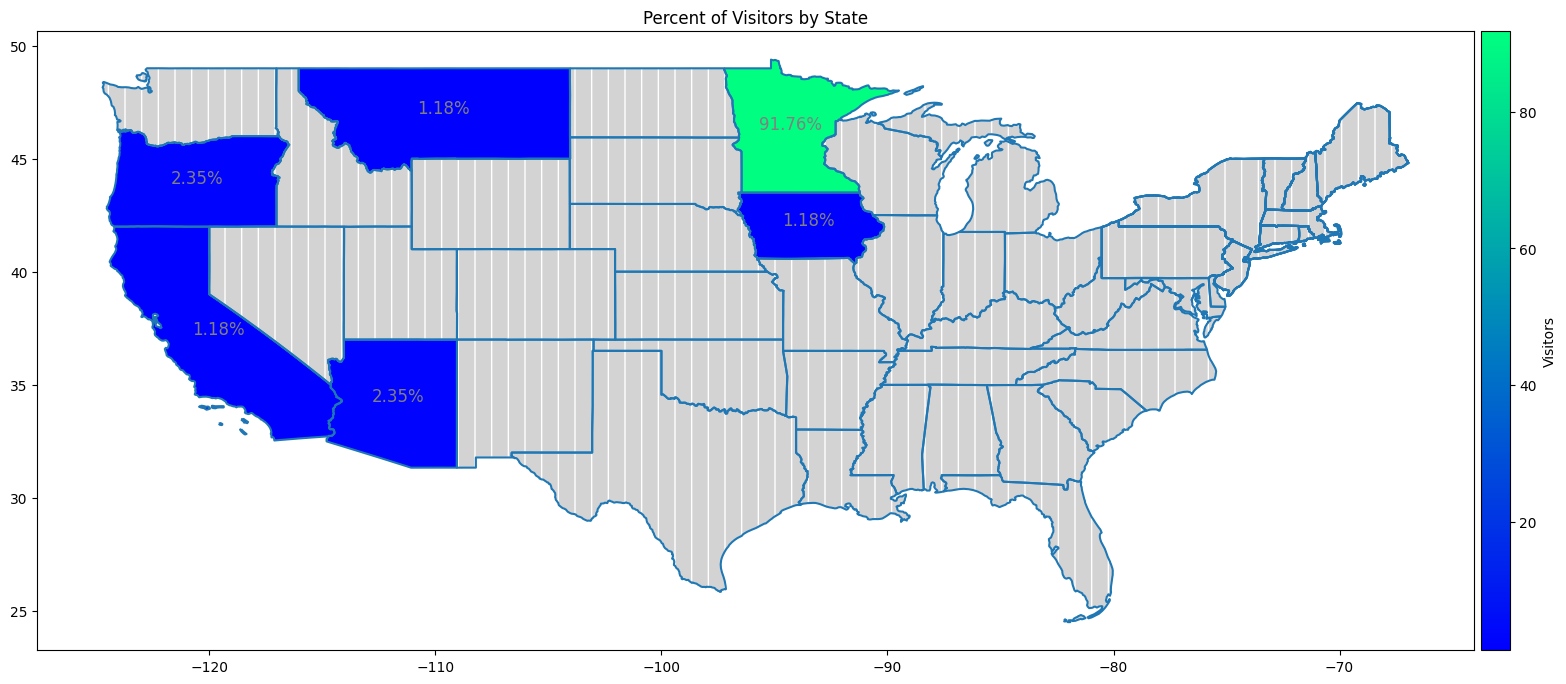

In [93]:
# Let's plot some Geo data
states = gpd.read_file("./data/usa-states-census-2014.shp") # Read in geometry data for US States
states = states.rename(columns={"NAME":"state"})            # Change the NAME column to state in prep for a merge

tmp_df = (
    (
        region_rider_df[region_rider_df['state'] != "unknown"].groupby('state').size().sort_values(ascending=False) / 
        region_rider_df[region_rider_df['state'] != "unknown"].groupby('state').size().sort_values(ascending=False).sum()
    ) * 100).to_frame().reset_index()

states_with_riders = tmp_df['state'].unique().tolist()

# Let's add in states that have no riders to the tmp_df
for index, row in states.iterrows():
    if row['state'] not in states_with_riders:
        tmp_df = pd.concat([tmp_df, pd.DataFrame.from_records([{'state': row['state']}])], ignore_index=True)

# Cast the rider df to a GeoDataFrame and merge it with states
geo_riders_df = gpd.GeoDataFrame(tmp_df)
geo_mapping = gpd.GeoDataFrame.merge(states, geo_riders_df, on="state")

# Get the center coordinate for each state in preparation for labeling
geo_mapping['coords'] = geo_mapping['geometry'].apply(lambda x: x.representative_point().coords[:])
geo_mapping['coords'] = [coords[0] for coords in geo_mapping['coords']]

# Generate the plot
ax = geo_mapping['geometry'].boundary.plot(figsize=(19, 18))
ax.set_title("Percent of Visitors by State")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad="0.5%")
geo_mapping.plot(
    ax=ax,
    cax=cax,
    column=0,
    legend=True,
    cmap='winter',
    missing_kwds={"color": "lightgrey", "edgecolor": "white", "hatch": "|"},
    legend_kwds={"label": "Visitors"},
    )

# Add the Labels to the plot
geo_mapping = geo_mapping.dropna()
geo_mapping.apply(lambda x: ax.annotate(text='{0:.2f}%'.format(x[0]), xy=x.geometry.centroid.coords[0], ha='center', color="grey", size=12), axis=1);
